<a href="https://colab.research.google.com/github/Egoago/Onlab/blob/main/%C3%96nlab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3D SDF regression with DNN

In [1]:
#@title Imports { form-width: "20%" }
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors, patches
from math import ceil
import tensorflow as tf
from tensorflow import norm
from tensorflow.math import reduce_mean, abs
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence
from tensorflow.keras.layers import Dense, Input, Dropout, ReLU, Softmax, Concatenate, ELU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.initializers import RandomNormal, Zeros, Constant
import keras
from keras import backend as K
from keras.layers import Layer
from skimage import measure
from mpl_toolkits.mplot3d import axes3d
from sklearn.preprocessing import normalize

%load_ext tensorboard
import datetime, os
!rm -rf ./sample_data

In [2]:
!nvidia-smi

Tue May  4 08:53:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Preparing the data

###Control points

control points: 35947


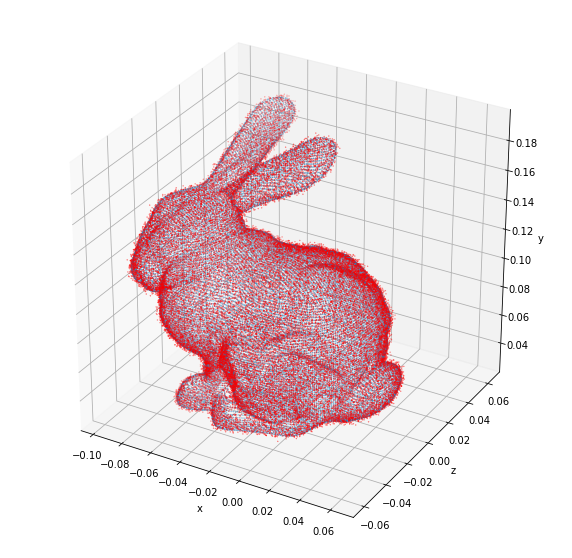

In [3]:
bunnyDataFrame = pd.read_csv('https://raw.githubusercontent.com/Egoago/Onlab/main/bunny.csv',
                             names=['x','y','z'],
                             sep=';',
                             index_col=False)
noise = np.random.normal(0, 0.001, bunnyDataFrame.shape)
noisyBunny = bunnyDataFrame + noise
plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(bunnyDataFrame['x'], -bunnyDataFrame['z'],bunnyDataFrame['y'],s=0.1)
ax.scatter3D(noisyBunny['x'], -noisyBunny['z'], noisyBunny['y'],s=0.1, c = 'r')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('y');
bunny = noisyBunny.to_numpy()
print(f'control points: {bunny.shape[0]}')

###Data Scaler

In [4]:
class Scaler():
  def __init__(self, data, normals = None):
    self.data = data
    self.mean = np.mean(data, axis=0)
    self.scale = np.max(np.abs(data-self.mean))*2
    self.trainingData = self.transform(data)
    self.normals = normals
  
  def getTrainingData(self):
    return self.trainingData

  def getMean(self):
    return self.mean

  def getScale(self):
    return self.scale

  def transform(self, x):
    return (x-self.mean)/self.scale

  def inverse(self, x):
    return x*self.scale+self.mean
  
  def getNormals(self):
    return self.normals

###Data generator

In [5]:
class Sampler(Sequence):
  seed = 0
  def __init__(self, batchCount, volumeSampleSize, surfaceSampleSize, controlPoints, controlNormals):
    self.batchCount = batchCount
    self.volumeSampleSize = volumeSampleSize
    self.surfaceSampleSize = surfaceSampleSize if surfaceSampleSize <= controlPoints.shape[0] else controlPoints.shape[0]
    self.controlPoints = controlPoints
    self.controlNormals = controlNormals
    self.seed = Sampler.seed
    Sampler.seed += 1
    self.randGen = np.random.default_rng(seed=self.seed)

  def __len__(self):
    return self.batchCount

  def __getitem__(self, idx):
    samples = self.randGen.random((self.volumeSampleSize,3))*2-1
    surfaceIndices = self.randGen.choice(self.controlPoints.shape[0],
                                         self.surfaceSampleSize)
    if controlNormals is not None:
      return samples, self.controlPoints[surfaceIndices], self.controlNormals[surfaceIndices]
    else:
      return samples, self.controlPoints[surfaceIndices]

  #def on_epoch_end(self):
    #self.randGen = np.random.default_rng(seed=self.seed)

##Preparing Model

In [6]:
#@title Creating model { form-width: "20%" }
class CustomModel(Model):
  def __init__(self, *args, **kwargs):
    super(CustomModel, self).__init__(*args, **kwargs)
    self.initialWeights = self.get_weights()

  def train_step(self, data):
    if self.useNormals:
      volumePoints, surfacePoints, surfaceNormals = data
    else:
      volumePoints, surfacePoints = data
    trainableVariables = self.trainable_variables

    with tf.GradientTape() as backpropTape:
      backpropTape.watch(trainableVariables)

      #Volume-eikonal
      with tf.GradientTape() as eikonalTape:
        eikonalTape.watch(volumePoints)
        volumePred = self(volumePoints, training=True)
      volumeGrad = eikonalTape.gradient(volumePred, volumePoints)
      eikonalLoss = tf.cast(reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2), dtype='float32')

      #Surface
      with tf.GradientTape() as surfaceTape:
        surfaceTape.watch(surfacePoints)
        surfacePred = self(surfacePoints, training=True)
      surfaceAbs = abs(surfacePred)
      if self.useNormals:
        surfaceGrad = surfaceTape.gradient(surfacePred, surfacePoints)
        surfaceAbs += self.normalLambda*norm(surfaceGrad-surfaceNormals, 2, -1)
      surfaceLoss = reduce_mean(surfaceAbs)

      loss = surfaceLoss + self.eikonalLambda * eikonalLoss

    self.optimizer.minimize(loss, trainableVariables, tape=backpropTape)
    return {"loss": loss}
  
  def test_step(self, data):
    volumePoints, surfacePoints, surfaceNormals = data

    #Volume-eikonal
    with tf.GradientTape() as eikonalTape:
      eikonalTape.watch(volumePoints)
      volumePred = self(volumePoints, training=True)
    volumeGrad = eikonalTape.gradient(volumePred, volumePoints)
    eikonalLoss = tf.cast(reduce_mean((norm(volumeGrad, 2, -1) - 1) ** 2), dtype='float32')

    #Surface
    with tf.GradientTape() as surfaceTape:
      surfaceTape.watch(surfacePoints)
      surfacePred = self(surfacePoints, training=True)
    surfaceAbs = abs(surfacePred)
    if surfaceNormals is not None:
      surfaceGrad = surfaceTape.gradient(surfacePred, surfacePoints)
      surfaceAbs += self.normalLambda*norm(surfaceGrad-surfaceNormals, 2, -1)
    surfaceLoss = reduce_mean(surfaceAbs)

    loss = surfaceLoss + self.eikonalLambda * eikonalLoss
    return {"loss": loss}

  def predict_step(self, data):
    #Surface
    with tf.GradientTape() as normalTape:
      normalTape.watch(data)
      distance = self(data, training=False)
    normal = normalTape.gradient(distance, data)
    return distance, normal
  
  def reset(self):
    self.set_weights(self.initialWeights)
  
  def compile(self, useNormals = False, eikonalLambda = 0.1, normalLambda = 1, *args, **kwargs):
    self.useNormals=useNormals
    self.eikonalLambda = eikonalLambda
    self.normalLambda = normalLambda
    super(CustomModel,self).compile(*args,**kwargs)
  
  def save(self, name):
    if len(name) > 0:
      savedPath = './saves/' + name
      compressedPath = name + '.zip'
      model.save_weights(savedPath+'/save')
      !zip -r {compressedPath} {savedPath}

  def load(self, name):
    if len(name) > 0:
      savedPath = './saves/' + name
      compressedPath =  + name + '.zip'
      !unzip {compressedPath}
      self.load_weights(savedPath + '/save')

In [7]:
#@title Softer Relu activation { display-mode: "form" }
class SofterRelu(Layer):
  epsilon = 1e-4
  def sRelu(x, beta=100):
    return K.log(K.exp(x*beta) + 1 + SofterRelu.epsilon)/beta

  def __init__(self, beta=100, trainable=False, **kwargs):
      super(SofterRelu, self).__init__(**kwargs)
      self.supports_masking = True
      self.beta = beta
      self.trainable = trainable

  def build(self, input_shape):
      self.beta_factor = K.variable(self.beta,
                                    dtype=K.floatx(),
                                    name='beta_factor')
      if self.trainable:
          self._trainable_weights.append(self.beta_factor)

      super(SofterRelu, self).build(input_shape)

  def call(self, inputs, mask=None):
      return SofterRelu.sRelu(inputs, self.beta_factor)

  def get_config(self):
      config = {'beta': self.get_weights()[0] if self.trainable else self.beta,
                'trainable': self.trainable}
      base_config = super(SofterRelu, self).get_config()
      return dict(list(base_config.items()) + list(config.items()))

  def compute_output_shape(self, input_shape):
      return input_shape



In [8]:
#@title 2D Plotting functions { form-width: "10px", display-mode: "form" }
def plotActivations():
  df = pd.DataFrame({"activation": np.linspace(-0.5,0.5,200)})
  df["relu"] = K.eval(keras.activations.relu(df["activation"]))
  df["softplus"] = K.eval(keras.activations.softplus(df["activation"]))
  df["elu"] = K.eval(keras.activations.elu(df["activation"]))
  df["softer relu, beta = 100"] = K.eval(SofterRelu()(df["activation"]))
  df["softer relu, beta = 10"] = K.eval(SofterRelu(10)(df["activation"]))
  df["softer relu, beta = 2"] = K.eval(SofterRelu(2)(df["activation"]))
  df.plot(x="activation", figsize=(5,5))

def plot(model, controlPoints=None, controlNormals=None, plotSize='big'):
    sizeDict = {
        'big': ((20,15), 200, 0.05,2),
        'medium': ((8,5), 100, 0.15,1),
        'small': ((4,3), 40, 0.2,1),
    }
    figSize, resolution, lineDensity, scale = sizeDict[plotSize]
    plt.figure(figsize=figSize)
    grid = np.empty((resolution*resolution,3))
    for y in range(resolution):
      for x in range(resolution):
        grid[y*resolution+x] = [(x/resolution-0.5)*2*scale, (y/resolution-0.5)*2*scale,0]
    prediction = np.array(model.predict(grid)[0].reshape((resolution,resolution)))
    del grid

    im = plt.imshow(prediction,
            cmap = sns.diverging_palette(220, 20, as_cmap=True),
            origin='lower',
            norm = colors.Normalize(vmin=-1, vmax=1),
            extent=(-scale,scale,-scale,scale))
    plt.colorbar(im)
    cset = plt.contour(prediction,
                       np.arange(-2, 2,lineDensity),
                       linewidths=2,
                       cmap='gray_r',
                       extent=(-scale,scale,-scale,scale))
    plt.clabel(cset,inline=True,fmt='%1.2f',fontsize=10)
    if controlPoints is not None:
      slice = controlPoints[np.abs(controlPoints[:,2])<0.01]
      plt.scatter(slice[:,0],
                  slice[:,1],
                  c='green', marker='o',
                  s=2,
                  alpha = 0.5,
                  label='control points')
      if controlNormals is not None:
        normalSlice = controlNormals[np.abs(controlPoints[:,2])<0.01]
        plt.quiver(slice[:,0],
                  slice[:,1],
                  normalSlice[:,0],
                  normalSlice[:,1],
                  color='green',
                  headlength = 3,
                  scale = 15,
                  alpha = 0.5,
                  headaxislength=3)
    if plotSize != 'big':
      plt.axis('off')
    else:
      plt.gca().add_patch(plt.Rectangle((-1,-1),2,2,
                    edgecolor='green',
                    facecolor='none',
                    lw=4, alpha=0.5))
      plt.contour(prediction,
                       0,
                       linewidths=2,
                       cmap='Reds_r',
                       extent=(-scale,scale,-scale,scale))
      print(f'maximum pred: {np.max(prediction)}')
      print(f'minimum pred: {np.min(prediction)}')
    del prediction
    plt.show()

class PlotCallback(Callback):
  def __init__(self, model, controlPoints=None, controlNormals=None, step=2):
    self.model = model
    self.controlPoints = controlPoints
    self.controlNormals = controlNormals
    self.step = step
    self.plots = []

  def on_train_begin(self, logs=None):
    print('Initial weights')
    plot(self.model, controlPoints, controlNormals, plotSize='medium')

  def on_epoch_end(self, epoch, logs=None):
    if (epoch%self.step == 0):
      plot(self.model, controlPoints, controlNormals, plotSize='small')
#plotActivations()

Trainable variables: 329470


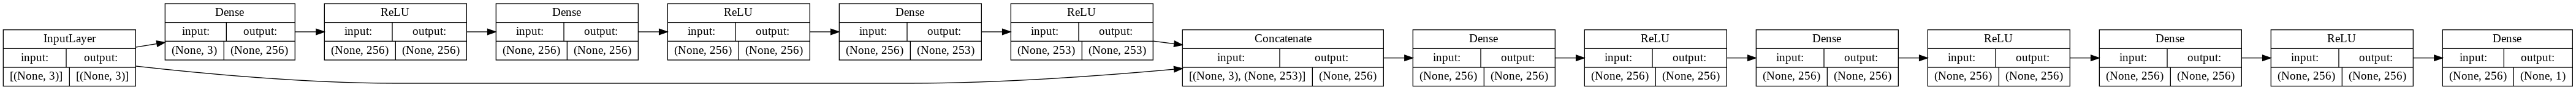

In [9]:
#@title Structure { run: "auto", form-width: "50%", display-mode: "form" }
layerCount = 6 #@param {type:"slider", min:1, max:8, step:1}
skipLayer = 3 #@param {type:"slider", min:0, max:8, step:1}
layerNeurons = 256 #@param {type:"slider", min:16, max:512, step:16}
activation = "relu" #@param ["relu", "softmax", "softerRelu", "elu"]
activationParam = 100 #@param {type:"number"}
useBatchNormalization = False #@param {type:"boolean"}

def getActivation():
  if activation == "softerRelu":
    return SofterRelu(activationParam)
  elif activation == "elu":
    return ELU(activationParam)
  elif activation == "relu":
    return ReLU()
  elif activation == "softmax":
    return Softmax()

inputLayer = Input(shape=(3,))
prevLayer = inputLayer
for i in range(1,layerCount+1):
  neurons = layerNeurons-3 if i == skipLayer else layerNeurons
  hiddenLayer = Dense(neurons,
                     kernel_initializer=RandomNormal(stddev=np.sqrt(2)/np.sqrt(layerNeurons)),
                     bias_initializer=Zeros())(prevLayer)
  prevLayer = getActivation()(hiddenLayer)
  if i == skipLayer:
    prevLayer = Concatenate()([inputLayer,prevLayer])
  if useBatchNormalization:
    prevLayer = tf.keras.layers.BatchNormalization()(prevLayer)
outputLayer = Dense(1,
                    activation='linear',
                    kernel_initializer= RandomNormal(mean=np.pi/np.sqrt(neurons), stddev=0.00001),
                    bias_initializer=Constant(-1)
                    )(prevLayer)

model = CustomModel(inputs = inputLayer, outputs = outputLayer)
model.compile(optimizer = Adam(lr = 0.0015))
#model.summary()
print(f'Trainable variables: {np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])}')
keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR')


##Train

Initial weights


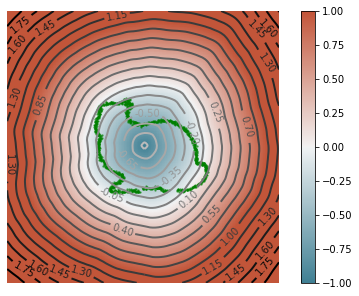

Epoch 1/10
5000/5000 [==============================] - 38s 7ms/step - loss: 0.0077


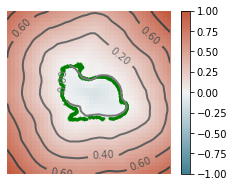

Epoch 2/10
5000/5000 [==============================] - 37s 7ms/step - loss: 0.0051


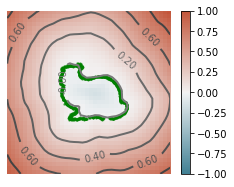

Epoch 3/10
5000/5000 [==============================] - 37s 7ms/step - loss: 0.0047


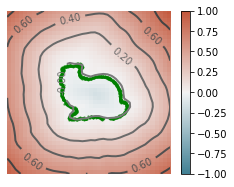

Epoch 4/10
5000/5000 [==============================] - 37s 7ms/step - loss: 0.0044


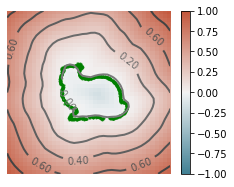

Epoch 5/10
5000/5000 [==============================] - 38s 8ms/step - loss: 0.0041


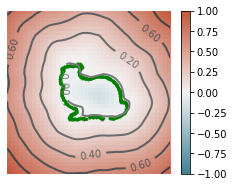

Epoch 6/10
5000/5000 [==============================] - 38s 8ms/step - loss: 0.0039


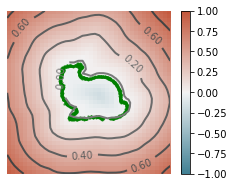

Epoch 7/10
5000/5000 [==============================] - 38s 8ms/step - loss: 0.0038


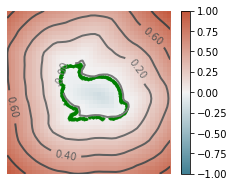

Epoch 8/10
5000/5000 [==============================] - 38s 8ms/step - loss: 0.0036


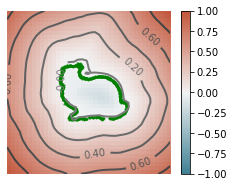

Epoch 9/10
5000/5000 [==============================] - 39s 8ms/step - loss: 0.0035


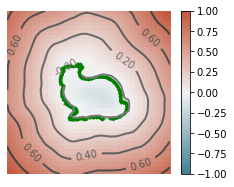

Epoch 10/10
5000/5000 [==============================] - 39s 8ms/step - loss: 0.0033


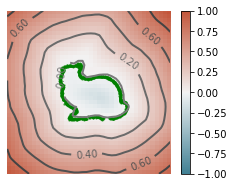

  adding: saves/bunnynoise/ (stored 0%)
  adding: saves/bunnynoise/save.index (deflated 70%)
  adding: saves/bunnynoise/checkpoint (deflated 35%)
  adding: saves/bunnynoise/save.data-00000-of-00001 (deflated 16%)


In [10]:
batchCount = 5000 #@param {type:"slider", min:10, max:10000, step:10}
volumeSampleSize =  512#@param {type:"number"}
surfaceSampleSize =  512#@param {type:"number"}
epochs =  10#@param {type:"integer"}
useNormals = False #@param {type:"boolean"}
reset = True #@param {type:"boolean"}
plotTraining = True #@param {type:"boolean"}
save = 'bunnynoise' #@param {type:"string"}
log = '' #@param {type:"string"}
normalLambda =  1#@param {type:"number"}
eikonalLambda = 0.1 #@param {type:"number"}
learningRate = 0.0001 #@param {type:"slider", min:0.0001, max:0.002, step:0.0001}

scaler = Scaler(bunny)
controlPoints = scaler.getTrainingData()
controlNormals = scaler.getNormals() if useNormals else None
if controlNormals == None:
  useNormals = False
if reset:
  model.reset()
callbacks = []
if plotTraining:
  callbacks.append(PlotCallback(model, controlPoints, controlNormals, 1))
if len(log)>0:
  logdir = os.path.join("logs", log)
  callbacks.append(tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1))
model.compile(optimizer = Adam(lr = learningRate),
              normalLambda = normalLambda,
              eikonalLambda = eikonalLambda,
              useNormals = useNormals)
history = model.fit(Sampler(batchCount = batchCount,
                                  volumeSampleSize = volumeSampleSize,
                                  surfaceSampleSize = surfaceSampleSize,
                                  controlPoints = controlPoints,
                                  controlNormals = controlNormals),
                    verbose = 1,
                    callbacks = callbacks,
                    epochs = epochs)
model.save(save)

In [11]:
#%tensorboard --logdir logs

maximum pred: 2.4320249557495117
minimum pred: -0.16773521900177002


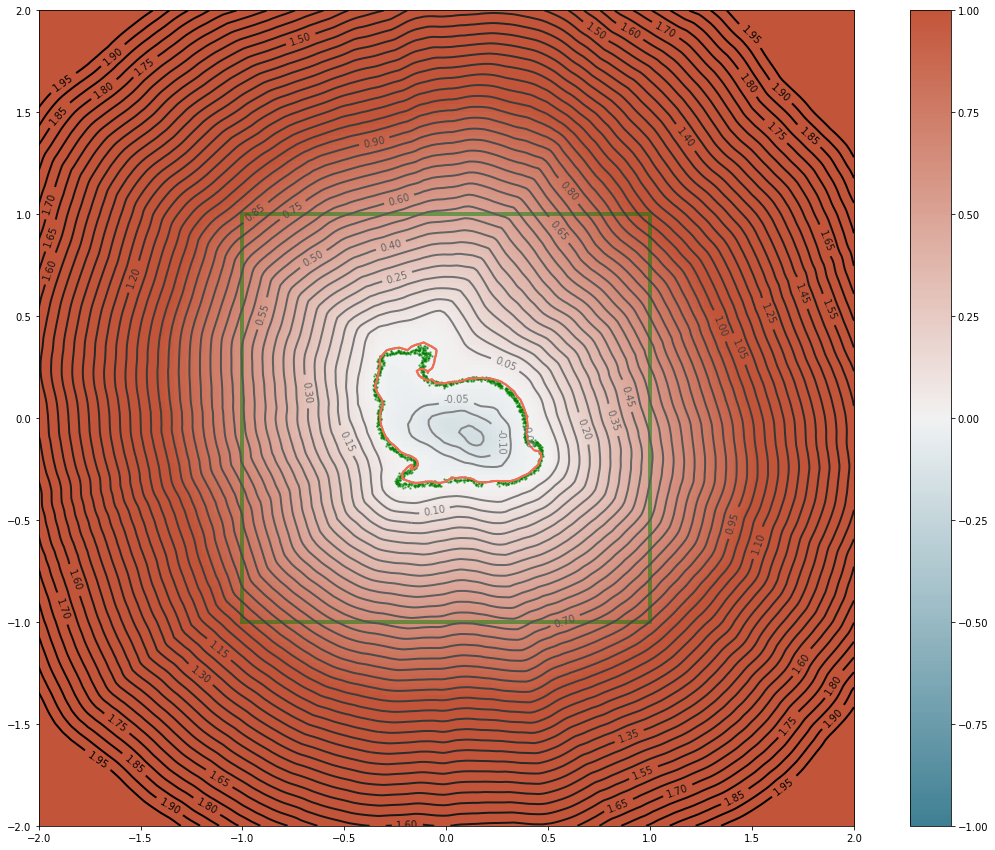

In [12]:
plot(model,  controlPoints, controlNormals)

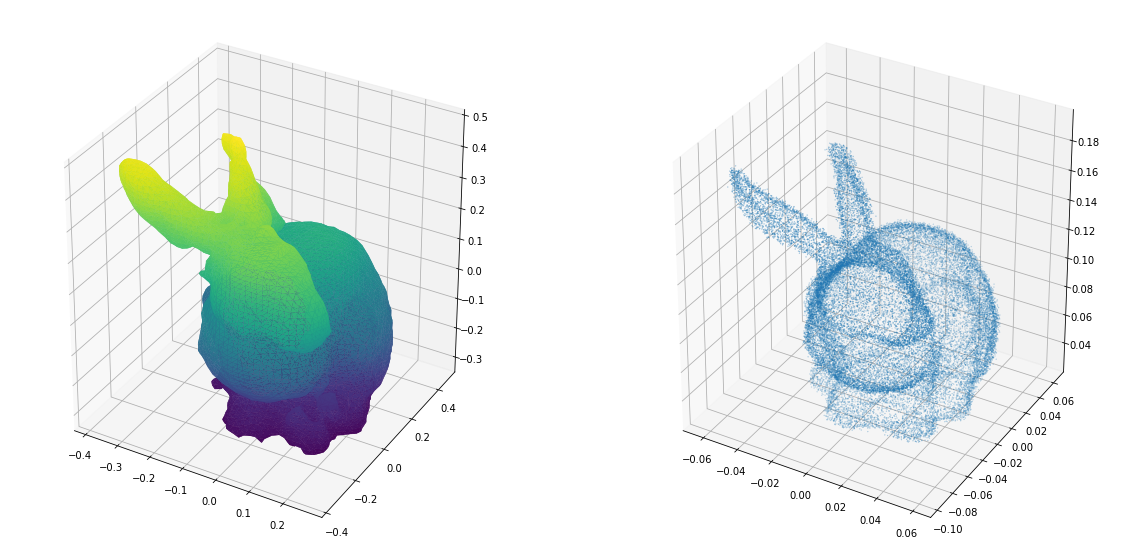

In [13]:
#@title Marching cubes { form-width: "20%" }
resolution = 256
xl = np.linspace(-2, 2, resolution)
grid = np.empty((resolution*resolution*resolution,3))
for y in range(resolution):
  for x in range(resolution):
    for z in range(resolution):
      grid[y*resolution*resolution+x*resolution+z] = [xl[x],xl[y],xl[z]]
distances, normals = model.predict(grid,batch_size=4096)
distances = distances.reshape(resolution,resolution,resolution)
verts, faces, marching_normals, values = measure.marching_cubes_lewiner(distances, 0, spacing=[np.diff(xl)[0]]*3)
verts -= 2
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')
ax.plot_trisurf(verts[:, 2], verts[:, 1], faces, verts[:, 0], cmap='viridis', lw=0)
ax = fig.add_subplot(122, projection='3d')
ax.scatter3D(bunny[:,2], bunny[:,0], bunny[:,1],s=0.05);

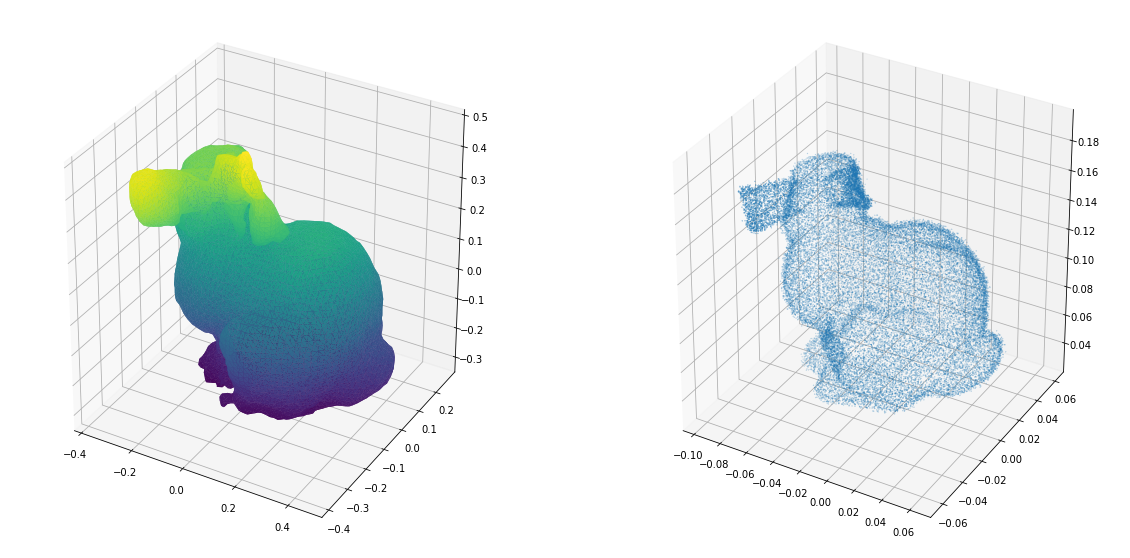

In [14]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(121, projection='3d')
ax.plot_trisurf(verts[:, 1], verts[:, 2], faces, verts[:, 0], cmap='viridis', lw=0)
ax = fig.add_subplot(122, projection='3d')
ax.scatter3D(bunny[:,0], bunny[:,2], bunny[:,1],s=0.05);

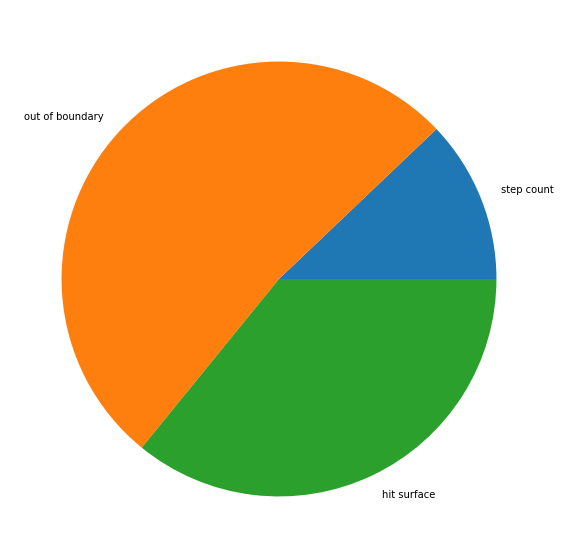

In [15]:
#@title Ray tracing { vertical-output: true, form-width: "20%" }
maxStep = 100 #@param {type:"slider", min:5, max:100, step:1}
epsilon =  1e-6#@param {type:"number"}
resolution = 512 #@param {type:"slider", min:32, max:1028, step:32}

class Ray:
  boundary = 0
  stepp = 0
  dist = 0

  def alive(ray):
    return ray.alive
  
  def getPos(ray):
    return ray.pos
  
  def getDistance(ray):
    return ray.distance
    
  def getNormal(ray):
    return ray.normal/2.0+0.5
  
  def step(ray, d, normal):
    ray.stepCount += 1
    ray.distance += d
    ray.pos += ray.dir*d
    ray.normal = normal
    if ray.distance > 2:
      Ray.boundary += 1
    if ray.stepCount > maxStep:
      Ray.stepp += 1
    if d < epsilon:
      Ray.dist += 1
    if ray.stepCount > maxStep or d < epsilon or ray.distance > 2:
      ray.alive = False
    return ray.alive

  def __init__(self, pos, dir):
    self.pos = pos
    self.dir = dir
    self.stepCount = 0
    self.distance = 0
    self.alive = True

xl = np.linspace(-0.5, 0.5, resolution)
rays = np.empty((resolution*resolution),Ray)
for y in range(resolution):
  for x in range(resolution):
    idx = y*resolution+x
    pos = np.array([xl[x],xl[y],1])
    dir = np.array([0,0,-1])
    rays[idx] = Ray(pos, dir)
aliveRays = rays
while aliveRays.size > 0:
  pos = np.array(list(map(Ray.getPos, aliveRays)))
  dist, normal = model.predict(pos,batch_size = 2048)
  normal = normalize(normal)
  aliveRays = aliveRays[np.array(list(map(Ray.step, aliveRays, dist, normal)))]
plt.figure(figsize=(10,10))
plt.pie([Ray.stepp, Ray.boundary, Ray.dist],labels=["step count", "out of boundary", "hit surface"]);

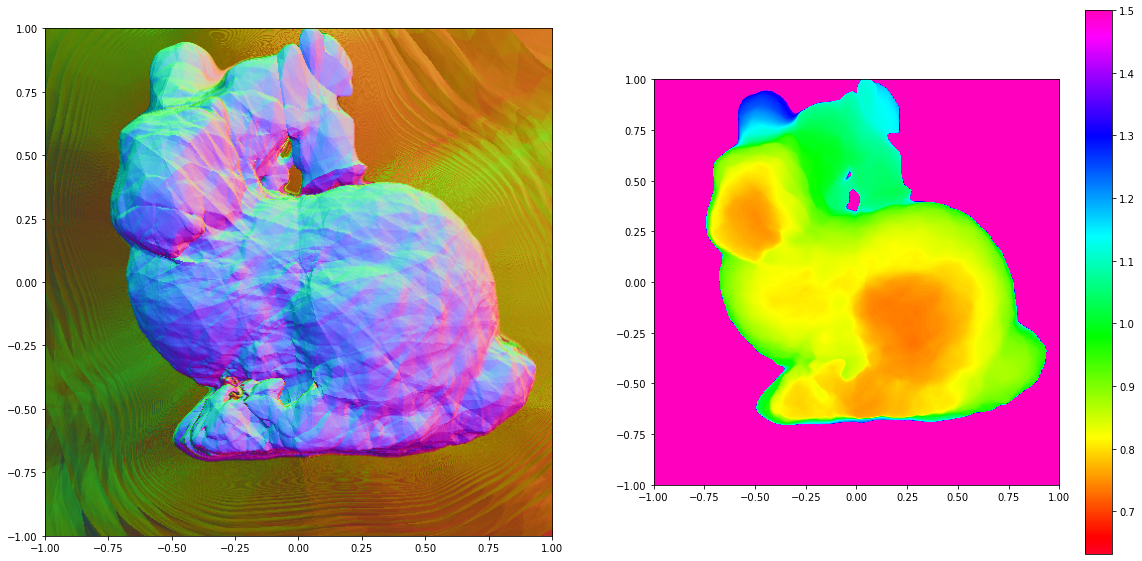

In [16]:
normalMap = np.array(list(map(Ray.getNormal, rays))).reshape((resolution,resolution,3))
distMap = np.array(list(map(Ray.getDistance, rays))).reshape((resolution,resolution))
np.save('bunnyNormalMap.npy', normalMap)
np.save('bunnyDistMap.npy', distMap)

fig, axs = plt.subplots(1,2)
fig.set_size_inches(20, 10)
axs[0].imshow(normalMap,
            origin='lower',
            extent=(-1,1,-1,1))
im = axs[1].imshow(distMap,
              cmap = 'gist_rainbow',
              origin='lower',
              norm = colors.Normalize(vmin=np.min(distMap)-0.1, vmax=1.5),
              extent=(-1,1,-1,1))
fig.colorbar(im);